# Batch Document Extraction with InternVL3-B (Non-Quantized)

This notebook tests non-quantized InternVL3-2B performance on V100 GPUs following the official documentation pattern.

**Testing Purpose**: Now that we've resolved underlying issues (Rich recursion, prompt repetition loops), we're testing whether InternVL3-2B can run without quantization as it did before the problems emerged.

**Official Pattern**: Follows https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html

This notebook includes steps for:
* loading documents
* detecting document types  
* extracting relevant information
* generating reports

## 1. Imports

In [1]:
#Cell 1
# Path setup for V100 systems - ensures proper module resolution
import sys
import os
from pathlib import Path
os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'


# Get the notebook's directory
notebook_path = Path().absolute()
print(f"📂 Current directory: {notebook_path}")

# Ensure the project root is in the Python path
if str(notebook_path) not in sys.path:
    sys.path.insert(0, str(notebook_path))
    print(f"✅ Added {notebook_path} to sys.path")

# Verify common module can be found
try:
    import common
    print(f"✅ Common module found at: {common.__file__ if hasattr(common, '__file__') else 'built-in'}")
except ImportError as e:
    print(f"❌ Common module not found: {e}")
    print("📋 Current sys.path:")
    for p in sys.path[:5]:  # Show first 5 paths
        print(f"   - {p}")

print("✅ Path setup complete - proceed to imports")

📂 Current directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Added /home/jovyan/nfs_share/tod/LMM_POC to sys.path
✅ Common module found at: /home/jovyan/nfs_share/tod/LMM_POC/common/__init__.py
✅ Path setup complete - proceed to imports


## 2. Path Setup (V100 Compatibility)

**IMPORTANT**: If you encounter import errors on V100 systems, this cell ensures proper module resolution.

In [2]:
#Cell 2
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
# This fixes import issues on multi-GPU V100 setups
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from rich import print as rprint
from rich.console import Console
from transformers import AutoModel, AutoTokenizer

# Project-specific imports - using absolute imports to avoid conflicts
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("✅ All imports loaded successfully")
print("✅ InternVL3 Hybrid Processor imported successfully") 
print("✅ Proven batch processing modules imported successfully")
print(f"📂 Working directory: {notebook_dir}")
print("🔬 NON-QUANTIZED MODE: Testing official InternVL3 pattern without quantization")
warnings.filterwarnings('ignore')

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
✅ All imports loaded successfully
✅ InternVL3 Hybrid Processor imported successfully
✅ Proven batch processing modules imported successfully
📂 Working directory: /home/jovyan/nfs_share/tod/LMM_POC
🔬 NON-QUANTIZED MODE: Testing official InternVL3 pattern without quantization


## 3. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [3]:
#Cell 3
# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 4. Configuration

In [ ]:
#Cell 4
# Initialize console and environment configuration
console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod/LMM_POC',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3-2B', #DANGER WILL ROBINSON
    # 'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3-8B',
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3-2B',
    
    # Batch settings
    'DATA_DIR': f'{base_data_path}/evaluation_data',
    'GROUND_TRUTH': f'{base_data_path}/evaluation_data/ground_truth.csv',
    # 'OUTPUT_BASE': f'{base_data_path}/output',
    'OUTPUT_BASE': f'{base_data_path}/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: True (inference-only mode)
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # InternVL3 optimization settings - NON-QUANTIZED TESTING
    # TESTING: Non-quantized performance after bug fixes (Rich recursion, prompt repetition)
    # This follows the official InternVL3 documentation pattern exactly
    'USE_QUANTIZATION': False,  # TESTING: Disabled to test non-quantized performance
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 600,
    'TORCH_DTYPE': 'bfloat16',
    'LOW_CPU_MEM_USAGE': True,
    # Flash Attention: NOT supported on V100, only enable for modern GPUs
    'USE_FLASH_ATTN': False,  # V100 compatible default
    
    # InternVL3-2B TILE CONFIGURATION
    'MAX_TILES': 18,  # InternVL3-2B config default
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Explicit file and key mapping
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# Structure:
#   'extraction_files': Maps document types to YAML prompt files
#   'extraction_keys': (Optional) Maps document types to specific keys in those files
#
# If 'extraction_keys' is not specified for a document type, the key will be
# derived from the document type name (e.g., 'INVOICE' -> 'invoice')
#
# For bank statements, structure classification (_flat or _date_grouped) is 
# automatically appended UNLESS you provide a full key in 'extraction_keys'
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': 'prompts/internvl3_prompts.yaml',
        'RECEIPT': 'prompts/internvl3_prompts.yaml', 
        'BANK_STATEMENT': 'prompts/internvl3_prompts.yaml'
    },
}

# Import field filtering from config to exclude validation-only fields
from common.config import get_v4_field_list, filter_evaluation_fields

# Get universal field list and filter out validation-only fields
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
# These fields are only for mathematical validation, not extraction/evaluation
UNIVERSAL_FIELDS = filter_evaluation_fields(get_v4_field_list())

print("✅ Configuration set up successfully")
print(f"📂 Evaluation data: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"🤖 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"📋 Universal fields: {len(UNIVERSAL_FIELDS)} (validation-only fields excluded)")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print(f"⚙️  Quantization: {'ENABLED (8-bit)' if CONFIG['USE_QUANTIZATION'] else 'DISABLED (full precision)'}")
print(f"⚡ Flash Attention: {'ENABLED' if CONFIG['USE_FLASH_ATTN'] else 'DISABLED (V100 compatible)'}")
print(f"🔲 Max Tiles: {CONFIG['MAX_TILES']} (InternVL3-2B default)")
print("🔬 TESTING: Non-quantized InternVL3 performance after bug fixes")

# 5. Output Directory Setup

In [5]:
#Cell 5
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# 6. Model Loading (Direct Official Pattern)

**NON-QUANTIZED TESTING**: Loading InternVL3 without quantization using the official documentation pattern to test whether the recent bug fixes (Rich recursion, prompt repetition) resolved the underlying issues.

In [ ]:
#Cell 6
# Load InternVL3 model using DIRECT official pattern (bypassing wrapper)
# https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html
rprint("[bold green]Loading InternVL3 model with official NON-QUANTIZED pattern...[/bold green]")
rprint("[cyan]🔬 Testing: Non-quantized performance after bug fixes[/cyan]")
rprint("[cyan]📖 Following: https://internvl.readthedocs.io/en/latest/internvl3.0/quick_start.html[/cyan]")

try:
    # Clear any existing CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        rprint("[blue]🧹 CUDA cache cleared[/blue]")
    
    # Load model using exact official pattern
    rprint("[cyan]📥 Loading model with official parameters...[/cyan]")
    model = AutoModel.from_pretrained(
        CONFIG['MODEL_PATH'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        use_flash_attn=False,  # V100 compatible
        trust_remote_code=True,
        device_map="auto"  # Distribute across available GPUs
    ).eval()
    
    # Load tokenizer
    rprint("[cyan]📥 Loading tokenizer...[/cyan]")
    tokenizer = AutoTokenizer.from_pretrained(
        CONFIG['MODEL_PATH'],
        trust_remote_code=True,
        use_fast=False
    )
    
    # Set generation parameters
    model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']
    
    # Display model information
    rprint("[green]✅ Model and tokenizer loaded successfully![/green]")
    
    # GPU memory check
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        rprint(f"[blue]📊 GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved, {total:.0f}GB total[/blue]")
        rprint(f"[blue]🔍 Memory usage: {(allocated/total*100):.1f}%[/blue]")
    
    # Model parameters
    param_count = sum(p.numel() for p in model.parameters())
    rprint(f"[blue]🔢 Model parameters: {param_count:,}[/blue]")
    rprint(f"[blue]🎯 Data type: {model.dtype}[/blue]")
    rprint(f"[blue]🖥️  Device: {next(model.parameters()).device}[/blue]")
    
    # Add device map diagnostic
    if hasattr(model, 'hf_device_map'):
        from collections import Counter
        device_distribution = Counter(model.hf_device_map.values())
        rprint(f"[blue]🔄 Model distribution: {dict(device_distribution)}[/blue]")
    else:
        rprint("[blue]📍 No device map found - model placed manually[/blue]")
    
    # Initialize the hybrid processor with loaded model components
    rprint("[cyan]🔧 Initializing document-aware processor...[/cyan]")
    hybrid_processor = DocumentAwareInternVL3HybridProcessor(
        field_list=UNIVERSAL_FIELDS,
        model_path=CONFIG['MODEL_PATH'],
        debug=CONFIG['VERBOSE'],
        pre_loaded_model=model,
        pre_loaded_tokenizer=tokenizer,
        prompt_config=PROMPT_CONFIG,  # Single source of truth for configuration!
        max_tiles=CONFIG['MAX_TILES']  # InternVL3-2B optimized tile configuration
    )
    
    rprint("[bold green]✅ InternVL3 NON-QUANTIZED model ready for document-aware processing[/bold green]")
    rprint(f"[cyan]🔲 Using {CONFIG['MAX_TILES']} tiles (InternVL3-2B default)[/cyan]")
    rprint("[yellow]🔬 If you see gibberish responses, it confirms quantization is still needed for V100[/yellow]")
    rprint("[yellow]🎉 If responses are clean, it proves the bug fixes resolved the core issues![/yellow]")
    
except Exception as e:
    rprint(f"[red]❌ Error loading model: {e}[/red]")
    rprint("[yellow]💡 This may indicate that quantization is still required for V100 GPUs[/yellow]")
    raise

# 7. Image Discovery

In [7]:
#Cell 7
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod/evaluation_data

Ground truth: /home/jovyan/nfs_share/tod/evaluation_data/ground_truth.csv

Mode: Evaluation mode

  1. image_001.png
  2. image_002.png
  3. image_003.png
  4. image_004.png
  5. image_005.png
  ... and 4 more


## 8. Batch Processing

In [8]:
#Cell 8
# Initialize batch processor with proven infrastructure (same pattern as llama_batch.ipynb)
processor = BatchDocumentProcessor(
    model=hybrid_processor,  # InternVL3 hybrid processor (handler)
    processor=None,          # Not needed for InternVL3
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Loaded ground truth for 9 images

📋 Sample GT keys: ['image_001.png', 'image_002.png', 'image_004.png']

🚀 Starting Batch Processing

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Output()

Processing [1/9]: image_001.png

🔍 TRACE: Processing InternVL3 image 1/9: image_001.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

✅ Detected Document Type: RECEIPT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'RECEIPT', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (589 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT  
BUSINESS_ABN: 06 082 698 025  
SUPPLIER_NAME: Liberty Oil  
BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000  
PAYER_NAME: Robert Taylor  
PAYER_ADDRESS: 243 Adelaide Street, Perth WA 6000  
INVOICE_DATE: 05/08/2025  
LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel  
LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3  
LINE_ITEM_PRICES: $15.00 each | $4.50 each | $1.65 each | $15.00 each | $1.70 each  
LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10  
IS_GST_INCLUDED: 10%  
GST_AMOUNT: $8.62  
TOTAL_AMOUNT: $94.87

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '06 082 698 025' -> '06082698025'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '481 Bourke Street  Perth WA 6000' -> 🏠 Address cleaned: '481 Bourke Street  
Perth WA 6000' -> '481 Bourke Street Perth WA 6000'

'481 Bourke Street Perth WA 6000'

🧹 CLEANER CALLED: PAYER_NAME: 'Robert Taylor' -> 'Robert Taylor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '243 Adelaide Street  Perth WA 6000' -> 🏠 Address cleaned: '243 Adelaide Street 
Perth WA 6000' -> '243 Adelaide Street Perth WA 6000'

'243 Adelaide Street Perth WA 6000'

🧹 CLEANER CALLED: INVOICE_DATE: '05/08/2025' -> '05/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel' -> 'Car 
Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 1 | 1 | 2 | 3' -> '3 | 1 | 1 | 2 | 3'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$15.00 each | $4.50 each | $1.65 each | $15.00 each | $1.70 each' -> '$15.00 
| $4.50 | $1.65 | $15.00 | $1.70'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$45.00 | $4.50 | $1.65 | $30.00 | $5.10' -> '$45.00 | $4.50 | $1.65 | 
$30.00 | $5.10'

🧹 CLEANER CALLED: IS_GST_INCLUDED: '10%' -> '10%'

🧹 CLEANER CALLED: GST_AMOUNT: '$8.62' -> '$8.62'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$94.87' -> '$94.87'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "06082698025"

✅ SUPPLIER_NAME: "Liberty Oil"

✅ BUSINESS_ADDRESS: "481 Bourke Street Perth WA 6000"

✅ PAYER_NAME: "Robert Taylor"

✅ PAYER_ADDRESS: "243 Adelaide Street Perth WA 6000"

✅ INVOICE_DATE: "05/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel"

✅ LINE_ITEM_QUANTITIES: "3 | 1 | 1 | 2 | 3"

✅ LINE_ITEM_PRICES: "$15.00 | $4.50 | $1.65 | $15.00 | $1.70"

✅ LINE_ITEM_TOTAL_PRICES: "$45.00 | $4.50 | $1.65 | $30.00 | $5.10"

✅ IS_GST_INCLUDED: "10%"

✅ GST_AMOUNT: "$8.62"

✅ TOTAL_AMOUNT: "$94.87"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 2.26GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_001.png, doc_type=RECEIPT

✓ Extracted 14 fields from image_001.png

🔍 BEFORE EVALUATION:

extracted_val = '10%' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: 10%

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_001.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [2/9]: image_002.png

🔍 TRACE: Processing InternVL3 image 2/9: image_002.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

✅ Detected Document Type: RECEIPT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'RECEIPT', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (627 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT  
BUSINESS_ABN: 29 466 483 258  
SUPPLIER_NAME: Ampol Limited  
BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800  
PAYER_NAME: Sophie Martin  
PAYER_ADDRESS: 467 Collins Street, Hobart TAS 7000  
INVOICE_DATE: 18/07/2025  
LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded  
LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2  
LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75  
LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50  
IS_GST_INCLUDED: NOT_FOUND  
GST_AMOUNT: $5.20  
TOTAL_AMOUNT: $57.15

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '29 466 483 258' -> '29466483258'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Ampol Limited' -> 'Ampol Limited'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '680 Collins Street  Darwin NT 0800' -> 🏠 Address cleaned: '680 Collins 
Street  Darwin NT 0800' -> '680 Collins Street Darwin NT 0800'

'680 Collins Street Darwin NT 0800'

🧹 CLEANER CALLED: PAYER_NAME: 'Sophie Martin' -> 'Sophie Martin'

🧹 CLEANER CALLED: PAYER_ADDRESS: '467 Collins Street  Hobart TAS 7000' -> 🏠 Address cleaned: '467 Collins Street 
Hobart TAS 7000' -> '467 Collins Street Hobart TAS 7000'

'467 Collins Street Hobart TAS 7000'

🧹 CLEANER CALLED: INVOICE_DATE: '18/07/2025' -> '18/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car
Wash | Premium Unleaded' -> 'Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium
Unleaded'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 1 | 2 | 2 | 2 | 2' -> '1 | 1 | 2 | 2 | 2 | 2'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75' -> '$4.20 | $1.75 | $4.50 | 
$1.75 | $15.00 | $1.75'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50' -> '$4.20 | $1.75 | 
$9.00 | $3.50 | $30.00 | $3.50'

🧹 CLEANER CALLED: GST_AMOUNT: '$5.20' -> '$5.20'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$57.15' -> '$57.15'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "29466483258"

✅ SUPPLIER_NAME: "Ampol Limited"

✅ BUSINESS_ADDRESS: "680 Collins Street Darwin NT 0800"

✅ PAYER_NAME: "Sophie Martin"

✅ PAYER_ADDRESS: "467 Collins Street Hobart TAS 7000"

✅ INVOICE_DATE: "18/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | 
Premium Unleaded"

✅ LINE_ITEM_QUANTITIES: "1 | 1 | 2 | 2 | 2 | 2"

✅ LINE_ITEM_PRICES: "$4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75"

✅ LINE_ITEM_TOTAL_PRICES: "$4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50"

❌ IS_GST_INCLUDED: "NOT_FOUND"

✅ GST_AMOUNT: "$5.20"

✅ TOTAL_AMOUNT: "$57.15"

================================================================================

✅ Extracted 13/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.26GB allocated, 2.29GB reserved

✅ Extracted 13/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_002.png, doc_type=RECEIPT

✓ Extracted 13 fields from image_002.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_002.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [3/9]: image_003.png

🔍 TRACE: Processing InternVL3 image 3/9: image_003.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_003.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_003.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (478 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "03/05/2025 to 10/05/2025",
  "LINE_ITEM_DESCRIPTIONS": "EFTPOS PURCHASE WOOLWORTHS | INTEREST PAYMENT | REFUND PROCESSED | DIRECT CREDIT 
SALARY | ATM WITHDRAWAL ANZ ATM",
  "TRANSACTION_DATES": "03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 | 
10/05/2025",
  "TRANSACTION_AMOUNTS_PAID": "288.03 | 22.50 | 114.66 | 3497.47 | 187.59 | 112.50 | 5.16 | 146.72"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '03/05/2025 to 10/05/2025' -> '03/05/2025 to 10/05/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'EFTPOS PURCHASE WOOLWORTHS | INTEREST PAYMENT | REFUND PROCESSED | 
DIRECT CREDIT SALARY | ATM WITHDR...' -> 'EFTPOS PURCHASE WOOLWORTHS | INTEREST PAYMENT | REFUND PROCESSED | DIRECT
CREDIT SALARY | ATM WITHDR...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 
| 09/05/2025 | 10/05/202...' -> '03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 
09/05/2025 | 10/05/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '288.03 | 22.50 | 114.66 | 3497.47 | 187.59 | 112.50 | 5.16 | 146.72' 
-> '288.03 | 22.50 | 114.66 | 3497.47 | 187.59 | 112.50 | 5.16 | 146.72'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "03/05/2025 to 10/05/2025"

✅ LINE_ITEM_DESCRIPTIONS: "EFTPOS PURCHASE WOOLWORTHS | INTEREST PAYMENT | REFUND PROCESSED | DIRECT CREDIT 
SALARY | ATM WITHDRAWAL ANZ ATM"

✅ TRANSACTION_DATES: "03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09/05/2025 |
10/05/2025"

✅ TRANSACTION_AMOUNTS_PAID: "288.03 | 22.50 | 114.66 | 3497.47 | 187.59 | 112.50 | 5.16 | 146.72"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.27GB allocated, 2.28GB reserved

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_003.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from image_003.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 50.9% for image_003.png

  Precision: 52.0% | Recall: 50.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [4/9]: image_004.png

🔍 TRACE: Processing InternVL3 image 4/9: image_004.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

✅ Detected Document Type: RECEIPT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (RECEIPT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing RECEIPT document with InternVL3

📝 Using receipt prompt (prompt_config): 741 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: RECEIPT

🔍 PARSING DEBUG - Raw response: 'RECEIPT'

🔍 PARSING DEBUG - Cleaned response: 'receipt'

✅ PARSING DEBUG - Found mapping: 'receipt' -> 'RECEIPT'

✅ Detected document type: RECEIPT

📋 DOCUMENT DETECTION RESULT: {'document_type': 'RECEIPT', 'confidence': 1.0, 'raw_response': 'RECEIPT', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'RECEIPT' → MAPPED TO: 'receipt'

📝 LOADING EXTRACTION PROMPT FOR: 'receipt'

📝 Loading receipt prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'receipt'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (741 chars):

================================================================================

Extract ALL data from this receipt image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find store: Business name at top
- Find transaction date: Use DD/MM/YYYY format
- Find purchased items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (527 chars):

================================================================================

DOCUMENT_TYPE: RECEIPT  
BUSINESS_ABN: 66 658 925 499  
SUPPLIER_NAME: Liberty Oil  
BUSINESS_ADDRESS: 993 Pitt Street, Darwin NT 0800  
PAYER_NAME: William Harris  
PAYER_ADDRESS: 52 Bourke Street, Darwin NT 0800  
INVOICE_DATE: 19/07/2025  
LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol  
LINE_ITEM_QUANTITIES: 1 | 2 | 3  
LINE_ITEM_PRICES: @ $1.75 each | @ $1.70 each | @ $1.65 each  
LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95  
IS_GST_INCLUDED: NOT_FOUND  
GST_AMOUNT: $1.01  
TOTAL_AMOUNT: $11.11

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'RECEIPT' -> 'RECEIPT'

🧹 CLEANER CALLED: BUSINESS_ABN: '66 658 925 499' -> '66658925499'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Liberty Oil' -> 'Liberty Oil'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '993 Pitt Street  Darwin NT 0800' -> 🏠 Address cleaned: '993 Pitt Street  
Darwin NT 0800' -> '993 Pitt Street Darwin NT 0800'

'993 Pitt Street Darwin NT 0800'

🧹 CLEANER CALLED: PAYER_NAME: 'William Harris' -> 'William Harris'

🧹 CLEANER CALLED: PAYER_ADDRESS: '52 Bourke Street  Darwin NT 0800' -> 🏠 Address cleaned: '52 Bourke Street  
Darwin NT 0800' -> '52 Bourke Street Darwin NT 0800'

'52 Bourke Street Darwin NT 0800'

🧹 CLEANER CALLED: INVOICE_DATE: '19/07/2025' -> '19/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Premium Unleaded | Diesel | Unleaded Petrol' -> 'Premium Unleaded | 
Diesel | Unleaded Petrol'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 2 | 3' -> '1 | 2 | 3'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '@ $1.75 each | @ $1.70 each | @ $1.65 each' -> '$1.75 | $1.70 | $1.65'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1.75 | $3.40 | $4.95' -> '$1.75 | $3.40 | $4.95'

🧹 CLEANER CALLED: GST_AMOUNT: '$1.01' -> '$1.01'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$11.11' -> '$11.11'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "RECEIPT"

✅ BUSINESS_ABN: "66658925499"

✅ SUPPLIER_NAME: "Liberty Oil"

✅ BUSINESS_ADDRESS: "993 Pitt Street Darwin NT 0800"

✅ PAYER_NAME: "William Harris"

✅ PAYER_ADDRESS: "52 Bourke Street Darwin NT 0800"

✅ INVOICE_DATE: "19/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Premium Unleaded | Diesel | Unleaded Petrol"

✅ LINE_ITEM_QUANTITIES: "1 | 2 | 3"

✅ LINE_ITEM_PRICES: "$1.75 | $1.70 | $1.65"

✅ LINE_ITEM_TOTAL_PRICES: "$1.75 | $3.40 | $4.95"

❌ IS_GST_INCLUDED: "NOT_FOUND"

✅ GST_AMOUNT: "$1.01"

✅ TOTAL_AMOUNT: "$11.11"

================================================================================

✅ Extracted 13/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.26GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.26GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 13/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_004.png, doc_type=RECEIPT

✓ Extracted 13 fields from image_004.png

🔍 BEFORE EVALUATION:

extracted_val = 'NOT_FOUND' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.9% for image_004.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [5/9]: image_005.png

🔍 TRACE: Processing InternVL3 image 5/9: image_005.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'INVOICE', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (638 chars):

================================================================================

```
DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 73 154 562 747
SUPPLIER_NAME: Aussie Office Supplies Pty Ltd
BUSINESS_ADDRESS: 23 Collins Street, Melbourne VIC 3000
PAYER_NAME: Perth Building Materials
PAYER_ADDRESS: 456 George Street, Sydney NSW 2000
INVOICE_DATE: 06/08/2025
LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand
LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1
LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24
LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24
IS_GST_INCLUDED: Total price includes GST
GST_AMOUNT: $439.46
TOTAL_AMOUNT: $4834.03
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '73 154 562 747' -> '73154562747'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Aussie Office Supplies Pty Ltd' -> 'Aussie Office Supplies Pty Ltd'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '23 Collins Street  Melbourne VIC 3000' -> 🏠 Address cleaned: '23 Collins 
Street  Melbourne VIC 3000' -> '23 Collins Street Melbourne VIC 3000'

'23 Collins Street Melbourne VIC 3000'

🧹 CLEANER CALLED: PAYER_NAME: 'Perth Building Materials' -> 'Perth Building Materials'

🧹 CLEANER CALLED: PAYER_ADDRESS: '456 George Street  Sydney NSW 2000' -> 🏠 Address cleaned: '456 George Street  
Sydney NSW 2000' -> '456 George Street Sydney NSW 2000'

'456 George Street Sydney NSW 2000'

🧹 CLEANER CALLED: INVOICE_DATE: '06/08/2025' -> '06/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor 
Stand' -> 'Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '3 | 3 | 2 | 3 | 1' -> '3 | 3 | 2 | 3 | 1'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$490.12 | $38.84 | $431.58 | $138.58 | $1968.24' -> '$490.12 | $38.84 | 
$431.58 | $138.58 | $1968.24'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24' -> '$1470.35 | 
$116.53 | $863.17 | $415.74 | $1968.24'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Total price includes GST' -> 'Total price includes GST'

🧹 CLEANER CALLED: GST_AMOUNT: '$439.46' -> '$439.46'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$4834.03' -> '$4834.03'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "73154562747"

✅ SUPPLIER_NAME: "Aussie Office Supplies Pty Ltd"

✅ BUSINESS_ADDRESS: "23 Collins Street Melbourne VIC 3000"

✅ PAYER_NAME: "Perth Building Materials"

✅ PAYER_ADDRESS: "456 George Street Sydney NSW 2000"

✅ INVOICE_DATE: "06/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand"

✅ LINE_ITEM_QUANTITIES: "3 | 3 | 2 | 3 | 1"

✅ LINE_ITEM_PRICES: "$490.12 | $38.84 | $431.58 | $138.58 | $1968.24"

✅ LINE_ITEM_TOTAL_PRICES: "$1470.35 | $116.53 | $863.17 | $415.74 | $1968.24"

✅ IS_GST_INCLUDED: "Total price includes GST"

✅ GST_AMOUNT: "$439.46"

✅ TOTAL_AMOUNT: "$4834.03"

================================================================================

✅ Extracted 14/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.27GB allocated, 2.28GB reserved

✅ Final GPU memory: 2.27GB allocated, 2.28GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 14/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_005.png, doc_type=INVOICE

✓ Extracted 14 fields from image_005.png

🔍 BEFORE EVALUATION:

extracted_val = 'Total price includes GST' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Total price includes GST

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 92.7% for image_005.png

  Precision: 92.7% | Recall: 92.7%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

[5/9] image_005.png: INVOICE - Accuracy: 92.7% - Time: 8.07s

Processing [6/9]: image_006.png

🔍 TRACE: Processing InternVL3 image 6/9: image_006.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'INVOICE', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([10, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (674 chars):

================================================================================

INVOICE

DOCUMENT_TYPE: INVOICE

SUPPLIER_NAME: Maritime Mechanics  
BUSINESS_ADDRESS: 1/92 Watt Road, Mornington, VIC 3931  
PAYER_NAME: Tod Nestor  
PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156  

INVOICE_DATE: 27/08/2025

LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete |
Freight - Parts In  
LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5  
LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00  
LINE_ITEM_TOTAL_PRICES: $3,749.84 | $3,749.84 | $3,749.84 | $3,749.84 | $990.00 | $1,530.00  
IS_GST_INCLUDED: Yes  
GST_AMOUNT: $374.98  
TOTAL_AMOUNT: $4,124.82

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Maritime Mechanics' -> 'Maritime Mechanics'

🧹 CLEANER CALLED: BUSINESS_ADDRESS: '1/92 Watt Road  Mornington  VIC 3931' -> 🏠 Address cleaned: '1/92 Watt Road 
Mornington  VIC 3931' -> '1/92 Watt Road Mornington VIC 3931'

'1/92 Watt Road Mornington VIC 3931'

🧹 CLEANER CALLED: PAYER_NAME: 'Tod Nestor' -> 'Tod Nestor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street  FERNTREE GULLY VIC 3156' -> 🏠 Address cleaned: '29 
Frederick Street  FERNTREE GULLY VIC 3156' -> '29 Frederick Street FERNTREE GULLY VIC 3156'

'29 Frederick Street FERNTREE GULLY VIC 3156'

🧹 CLEANER CALLED: INVOICE_DATE: '27/08/2025' -> '27/08/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | 
Labour - To Complete | Freight ...' -> 'VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour
- To Complete | Freight ...'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5' -> '1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00' -> '$356.25 | 
$86.87 | $181.25 | $478.60 | $180.00 | $180.00'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$3,749.84 | $3,749.84 | $3,749.84 | $3,749.84 | $990.00 | $1,530.00' ->
'$3749.84 | $3749.84 | $3749.84 | $3749.84 | $990.00 | $1530.00'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'Yes' -> 'Yes'

🧹 CLEANER CALLED: GST_AMOUNT: '$374.98' -> '$374.98'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$4,124.82' -> '$4124.82'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

❌ BUSINESS_ABN: "NOT_FOUND"

✅ SUPPLIER_NAME: "Maritime Mechanics"

✅ BUSINESS_ADDRESS: "1/92 Watt Road Mornington VIC 3931"

✅ PAYER_NAME: "Tod Nestor"

✅ PAYER_ADDRESS: "29 Frederick Street FERNTREE GULLY VIC 3156"

✅ INVOICE_DATE: "27/08/2025"

✅ LINE_ITEM_DESCRIPTIONS: "VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To 
Complete | Freight - Parts In"

✅ LINE_ITEM_QUANTITIES: "1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5"

✅ LINE_ITEM_PRICES: "$356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00"

✅ LINE_ITEM_TOTAL_PRICES: "$3749.84 | $3749.84 | $3749.84 | $3749.84 | $990.00 | $1530.00"

✅ IS_GST_INCLUDED: "Yes"

✅ GST_AMOUNT: "$374.98"

✅ TOTAL_AMOUNT: "$4124.82"

================================================================================

✅ Extracted 13/14 fields

Found: ['DOCUMENT_TYPE', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.26GB allocated, 2.28GB reserved

✅ Extracted 13/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_006.png, doc_type=INVOICE

✓ Extracted 13 fields from image_006.png

🔍 BEFORE EVALUATION:

extracted_val = 'Yes' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: Yes

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 80.6% for image_006.png

  Precision: 85.7% | Recall: 78.6%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [7/9]: image_007.png

🔍 TRACE: Processing InternVL3 image 7/9: image_007.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

✅ Detected Document Type: INVOICE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (INVOICE)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing INVOICE document with InternVL3

📝 Using invoice prompt (prompt_config): 762 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: INVOICE

🔍 PARSING DEBUG - Raw response: 'INVOICE'

🔍 PARSING DEBUG - Cleaned response: 'invoice'

✅ PARSING DEBUG - Found mapping: 'invoice' -> 'INVOICE'

✅ Detected document type: INVOICE

📋 DOCUMENT DETECTION RESULT: {'document_type': 'INVOICE', 'confidence': 1.0, 'raw_response': 'INVOICE', 
'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'INVOICE' → MAPPED TO: 'invoice'

📝 LOADING EXTRACTION PROMPT FOR: 'invoice'

📝 Loading invoice prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 14 fields for 'invoice'

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🔍 DOCUMENT-AWARE PROMPT (762 chars):

================================================================================

Extract ALL data from this invoice image. Respond in exact format below with actual values or NOT_FOUND.

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: NOT_FOUND
SUPPLIER_NAME: NOT_FOUND
BUSINESS_ADDRESS: NOT_FOUND
PAYER_NAME: NOT_FOUND
PAYER_ADDRESS: NOT_FOUND
INVOICE_DATE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
LINE_ITEM_QUANTITIES: NOT_FOUND
LINE_ITEM_PRICES: NOT_FOUND
LINE_ITEM_TOTAL_PRICES: NOT_FOUND
IS_GST_INCLUDED: NOT_FOUND
GST_AMOUNT: NOT_FOUND
TOTAL_AMOUNT: NOT_FOUND

Instructions:
- Find ABN: 11 digits like "12 345 678 901"
- Find supplier: Business name at top
- Find customer: "Bill To" section
- Find date: Use DD/MM/YYYY format
- Find line items: List with " | " separator
- Find amounts: Include $ symbol
- Replace NOT_FOUND with actual values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (769 chars):

================================================================================

DOCUMENT_TYPE: INVOICE  
BUSINESS_ABN: 64 086 174 781  
SUPPLIER_NAME: Telstra Limited  
BUSINESS_ADDRESS: NOT_FOUND  
PAYER_NAME: Mr Maurice Nestor  
PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156  
INVOICE_DATE: 16 Jul 2025  
LINE_ITEM_DESCRIPTIONS: Mobile service 0422 521 734 | Telstra Upfront Mobile Plan Starter | Mobile data service 
0459 246 813 | Telstra Upfront Data Plan Small | Mobile data service 0409 760 513 | Telstra Upfront Data Plan Small
| Mobile data service 0428 992 418 | Telstra Upfront Data Plan Small  
LINE_ITEM_QUANTITIES: 1 | 1 | 1 | 1  
LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00  
LINE_ITEM_TOTAL_PRICES: $45.00 | $30.00 | $25.00 | $20.00  
IS_GST_INCLUDED: YES  
GST_AMOUNT: $10.91  
TOTAL_AMOUNT: $120.00  
NOT_FOUND

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'INVOICE' -> 'INVOICE'

🧹 CLEANER CALLED: BUSINESS_ABN: '64 086 174 781' -> '64086174781'

🧹 CLEANER CALLED: SUPPLIER_NAME: 'Telstra Limited' -> 'Telstra Limited'

🧹 CLEANER CALLED: PAYER_NAME: 'Mr Maurice Nestor' -> 'Mr Maurice Nestor'

🧹 CLEANER CALLED: PAYER_ADDRESS: '29 Frederick Street  FERNTREE GULLY VIC 3156' -> 🏠 Address cleaned: '29 
Frederick Street  FERNTREE GULLY VIC 3156' -> '29 Frederick Street FERNTREE GULLY VIC 3156'

'29 Frederick Street FERNTREE GULLY VIC 3156'

🧹 CLEANER CALLED: INVOICE_DATE: '16/07/2025' -> '16/07/2025'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Mobile service 0422 521 734 | Telstra Upfront Mobile Plan Starter | 
Mobile data service 0459 246 813...' -> 'Mobile service 0422 521 734 | Telstra Upfront Mobile Plan Starter | Mobile
data service 0459 246 813...'

🧹 CLEANER CALLED: LINE_ITEM_QUANTITIES: '1 | 1 | 1 | 1' -> '1 | 1 | 1 | 1'

🧹 CLEANER CALLED: LINE_ITEM_PRICES: '$45.00 | $30.00 | $25.00 | $20.00' -> '$45.00 | $30.00 | $25.00 | $20.00'

🧹 CLEANER CALLED: LINE_ITEM_TOTAL_PRICES: '$45.00 | $30.00 | $25.00 | $20.00' -> '$45.00 | $30.00 | $25.00 | 
$20.00'

🧹 CLEANER CALLED: IS_GST_INCLUDED: 'YES' -> 'YES'

🧹 CLEANER CALLED: GST_AMOUNT: '$10.91' -> '$10.91'

🧹 CLEANER CALLED: TOTAL_AMOUNT: '$120.00' -> '$120.00'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "INVOICE"

✅ BUSINESS_ABN: "64086174781"

✅ SUPPLIER_NAME: "Telstra Limited"

❌ BUSINESS_ADDRESS: "NOT_FOUND"

✅ PAYER_NAME: "Mr Maurice Nestor"

✅ PAYER_ADDRESS: "29 Frederick Street FERNTREE GULLY VIC 3156"

✅ INVOICE_DATE: "16/07/2025"

✅ LINE_ITEM_DESCRIPTIONS: "Mobile service 0422 521 734 | Telstra Upfront Mobile Plan Starter | Mobile data 
service 0459 246 813 | Telstra Upfront Data Plan Small | Mobile data service 0409 760 513 | Telstra Upfront Data 
Plan Small | Mobile data service 0428 992 418 | Telstra Upfront Data Plan Small"

✅ LINE_ITEM_QUANTITIES: "1 | 1 | 1 | 1"

✅ LINE_ITEM_PRICES: "$45.00 | $30.00 | $25.00 | $20.00"

✅ LINE_ITEM_TOTAL_PRICES: "$45.00 | $30.00 | $25.00 | $20.00"

✅ IS_GST_INCLUDED: "YES"

✅ GST_AMOUNT: "$10.91"

✅ TOTAL_AMOUNT: "$120.00"

================================================================================

✅ Extracted 13/14 fields

Found: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.26GB allocated, 2.29GB reserved

✅ Final GPU memory: 2.26GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 13/14 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_007.png, doc_type=INVOICE

✓ Extracted 13 fields from image_007.png

🔍 BEFORE EVALUATION:

extracted_val = 'YES' (type: str)

ground_val = 'true' (type: str)

Are they equal? False

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: YES

Ground truth: true

Parsed extracted: None

Parsed ground truth: True

Match: False

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 0.0

✓ Overall F1 Score (Accuracy): 78.6% for image_007.png

  Precision: 78.6% | Recall: 78.6%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=14

Processing [8/9]: image_008.png

🔍 TRACE: Processing InternVL3 image 8/9: image_008.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_008.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_008.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (2000 chars):

================================================================================

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 08/08/2025 to 07/09/2025
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: 07/09/2025 |  08/09/2025 |  09/03/2025 |  03/09/2025 |  02/09/2025 |  01/09/2025 |  01/08/2025 |
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  
08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/2025 |  08/08/20

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '08/08/2025 to 07/09/2025' -> '08/08/2025 to 07/09/2025'

🧹 CLEANER CALLED: TRANSACTION_DATES: '07/09/2025 | 08/09/2025 | 09/03/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 
| 01/08/2025 | 08/08/202...' -> '07/09/2025 | 08/09/2025 | 09/03/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 
01/08/2025 | 08/08/202...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "08/08/2025 to 07/09/2025"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

✅ TRANSACTION_DATES: "07/09/2025 | 08/09/2025 | 09/03/2025 | 03/09/2025 | 02/09/2025 | 01/09/2025 | 01/08/2025 |
08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 
| 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 
08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 
| 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 
08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 
| 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 
08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 
| 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 
08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 
| 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 
08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 
| 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 
08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 
| 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 
08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2025 | 08/08/2020"

❌ TRANSACTION_AMOUNTS_PAID: "NOT_FOUND"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 3/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 2.26GB allocated, 2.29GB reserved

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 41.4% for image_008.png

  Precision: 40.9% | Recall: 43.3%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [9/9]: image_009.png

🔍 TRACE: Processing InternVL3 image 9/9: image_009.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_009.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: image_009.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 19 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📄 RAW MODEL RESPONSE (864 chars):

```json
{
  DOCUMENT_TYPE: BANK_STATEMENT
  STATEMENT_DATE_RANGE: "07 Aug 2025 to 06 Sep  2205"
  LINE_ITEM_DESCRIPTIONS: "Thu  04 Sep 2025 | Mon  01 Sep 2025 | Sun  31 Aug 2025 | Fri  29 Aug 2025 | Wed  27 Aug 
2025 | Sat  23 Aug  2025 | Thu  21 Aug 2025 | Tue  19 Aug  2025 | Sun  17 Aug 2025 | Sat  16 Aug 2025 | Fri  15 Aug
2025 | Wed  13 Aug 2025 | Mon  11 Aug 2025"
  TRANSACTION_DATES: "Thu 04 Sep 2025 | Mon 01 Sep 2025 | Sun 31 Aug 2025 | Fri 29 Aug  2025 | Wed 27 Aug 2025 | 
Sat 23 Aug  2025 | Thu 21 Aug 2025 | Tue 19 Aug 2025 | Sun 17 Aug 2025 | Sat 16 Aug 2025 | Fri 15 Aug 2025 | Wed 13
Aug 2025 | Mon 11 Aug 2025"
  TRANSACTION_AMOUNTS_PAID: "$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $276.31 | $61.68 |
$3775.28 | $5778.51 | $245.00 | $51.36 | $228.11 | $4374.15 | $214.26 | $2221.48 | $1993.37 | $4814.35 | $4600.09"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '"07 Aug 2025 to 06 Sep  2205"' -> '"07 Aug 2025 to 06 Sep 2205"'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: '"Thu  04 Sep 2025 | Mon  01 Sep 2025 | Sun  31 Aug 2025 | Fri  29 Aug 
2025 | Wed  27 Aug 2025 | Sat ...' -> '"Thu 04 Sep 2025 | Mon 01 Sep 2025 | Sun 31 Aug 2025 | Fri 29 Aug 2025 | Wed
27 Aug 2025 | Sat 23 Au...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '"Thu 04 Sep 2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 
23/08/2025 | 21/08/2025 | 19/...' -> '"Thu 04 Sep 2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 
23/08/2025 | 21/08/2025 | 19/...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '"$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | 
$276.31 | $61.68 | $3775.28 | $...' -> '"$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | 
$276.31 | $61.68 | $3775.28 | $...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: ""07 Aug 2025 to 06 Sep 2205""

✅ LINE_ITEM_DESCRIPTIONS: ""Thu 04 Sep 2025 | Mon 01 Sep 2025 | Sun 31 Aug 2025 | Fri 29 Aug 2025 | Wed 27 Aug 
2025 | Sat 23 Aug 2025 | Thu 21 Aug 2025 | Tue 19 Aug 2025 | Sun 17 Aug 2025 | Sat 16 Aug 2025 | Fri 15 Aug 2025 | 
Wed 13 Aug 2025 | Mon 11 Aug 2025""

✅ TRANSACTION_DATES: ""Thu 04 Sep 2025 | 01/09/2025 | 31/08/2025 | 29/08/2025 | 27/08/2025 | 23/08/2025 | 
21/08/2025 | 19/08/2025 | 17/08/2025 | 16/08/2025 | 15/08/2025 | 13/08/2025 | Mon 11 Aug 2025""

✅ TRANSACTION_AMOUNTS_PAID: ""$117.57 | $17.89 | $18.87 | $241.14 | $251.33 | $98.53 | $1918.75 | $276.31 | 
$61.68 | $3775.28 | $5778.51 | $245.00 | $51.36 | $228.11 | $4374.15 | $214.26 | $2221.48 | $1993.37 | $4814.35 | 
$4600.09""

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 2.26GB allocated, 2.29GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for image_009.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from image_009.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 43.8% for image_009.png

  Precision: 52.9% | Recall: 40.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

[9/9] image_009.png: BANK_STATEMENT - Accuracy: 43.8% - Time: 13.61s

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 9 images

Average time: 12.66s

Average accuracy: 74.1%

## 9. Generate Analytics

In [9]:
#Cell 9
# Create model-specific CSV file to match Llama structure
# Define all field columns that should be in the CSV (matching Llama)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED',
    'ACCOUNT_BALANCE'
]

# Create comprehensive results data matching Llama structure
internvl3_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier (mark as non-quantized)
    prompt_used = f"internvl3_non_quantized_{doc_type}" if doc_type else "internvl3_non_quantized_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY'],
        'quantization_used': False  # Mark as non-quantized
    }
    
    # Add all field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_csv_data.append(row_data)

# Create DataFrame and save
internvl3_df = pd.DataFrame(internvl3_csv_data)
internvl3_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_non_quantized_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_df.to_csv(internvl3_csv_path, index=False)

rprint("[bold green]✅ InternVL3 NON-QUANTIZED model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {internvl3_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(internvl3_df)} rows × {len(internvl3_df.columns)} columns[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *internvl3*non*quantized*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'quantization_used']
    if len(internvl3_df) > 0:
        display(internvl3_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'quantization_used']
    if len(internvl3_df) > 0:
        display(internvl3_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:3]):  # Show first 3
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 InternVL3 NON-QUANTIZED Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {internvl3_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {internvl3_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

✅ InternVL3 NON-QUANTIZED model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/internvl3_non_quantized_batch_results_20251115_035828.csv

📊 Structure: 9 rows × 34 columns

🔗 Compatible with model_comparison.ipynb pattern: *internvl3*non*quantized*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,quantization_used
0,image_001.png,receipt,92.857143,7.746201,14,False
1,image_002.png,receipt,92.857143,7.254935,13,False
2,image_003.png,bank_statement,50.909091,8.927206,5,False


🔍 Accuracy verification:

image_001.png: 0.9286 → 92.86%

image_002.png: 0.9286 → 92.86%

image_003.png: 0.5091 → 50.91%

✅ DataFrames saved to /home/jovyan/nfs_share/tod/LMM_POC/output/csv

📊 InternVL3 NON-QUANTIZED Results Summary

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),74.071598
Median Accuracy (%),80.647131
Min Accuracy (%),41.438849
Max Accuracy (%),92.857143
Average Processing Time (s),12.656225
Total Processing Time (s),113.906023
Throughput (images/min),4.740750


## 10. Export Model-Specific CSV for Comparison

Create InternVL3 NON-QUANTIZED specific CSV file that matches Llama structure for model comparison:

In [10]:
#Cell 10
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod/LMM_POC/output/visualizations/dashboard_20251115_035828.png

⚠️ No field-level accuracy data available

## 11. Generate Reports

In [11]:
#Cell 11
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to /home/jovyan/nfs_share/tod/LMM_POC/output/reports/batch_report_20251115_035828.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod/LMM_POC/output/batch_results/batch_results_20251115_035828.json

## 12. Display Final Summary

──────────────────────────────── InternVL3 NON-QUANTIZED Batch Processing Complete ────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Overall Average Accuracy (across all images): 74.07%

📊 Breakdown by Document Type:

  RECEIPT: 92.9% (n=3 images)

  INVOICE: 84.0% (n=3 images)

  BANK_STATEMENT: 45.4% (n=3 images)

Output: /home/jovyan/nfs_share/tod/LMM_POC/output

🔬 QUANTIZATION: DISABLED (testing non-quantized performance)

🎉 SUCCESS: Non-quantized InternVL3 appears to be working correctly!

✅ This proves the bug fixes (Rich recursion, prompt repetition) resolved the core issues

✅ InternVL3-2B can run without quantization as it did before the problems emerged

📋 Document Type Distribution:

  RECEIPT: 3 documents (33.3%)

  BANK_STATEMENT: 3 documents (33.3%)

  INVOICE: 3 documents (33.3%)

📊 Visual Dashboard:

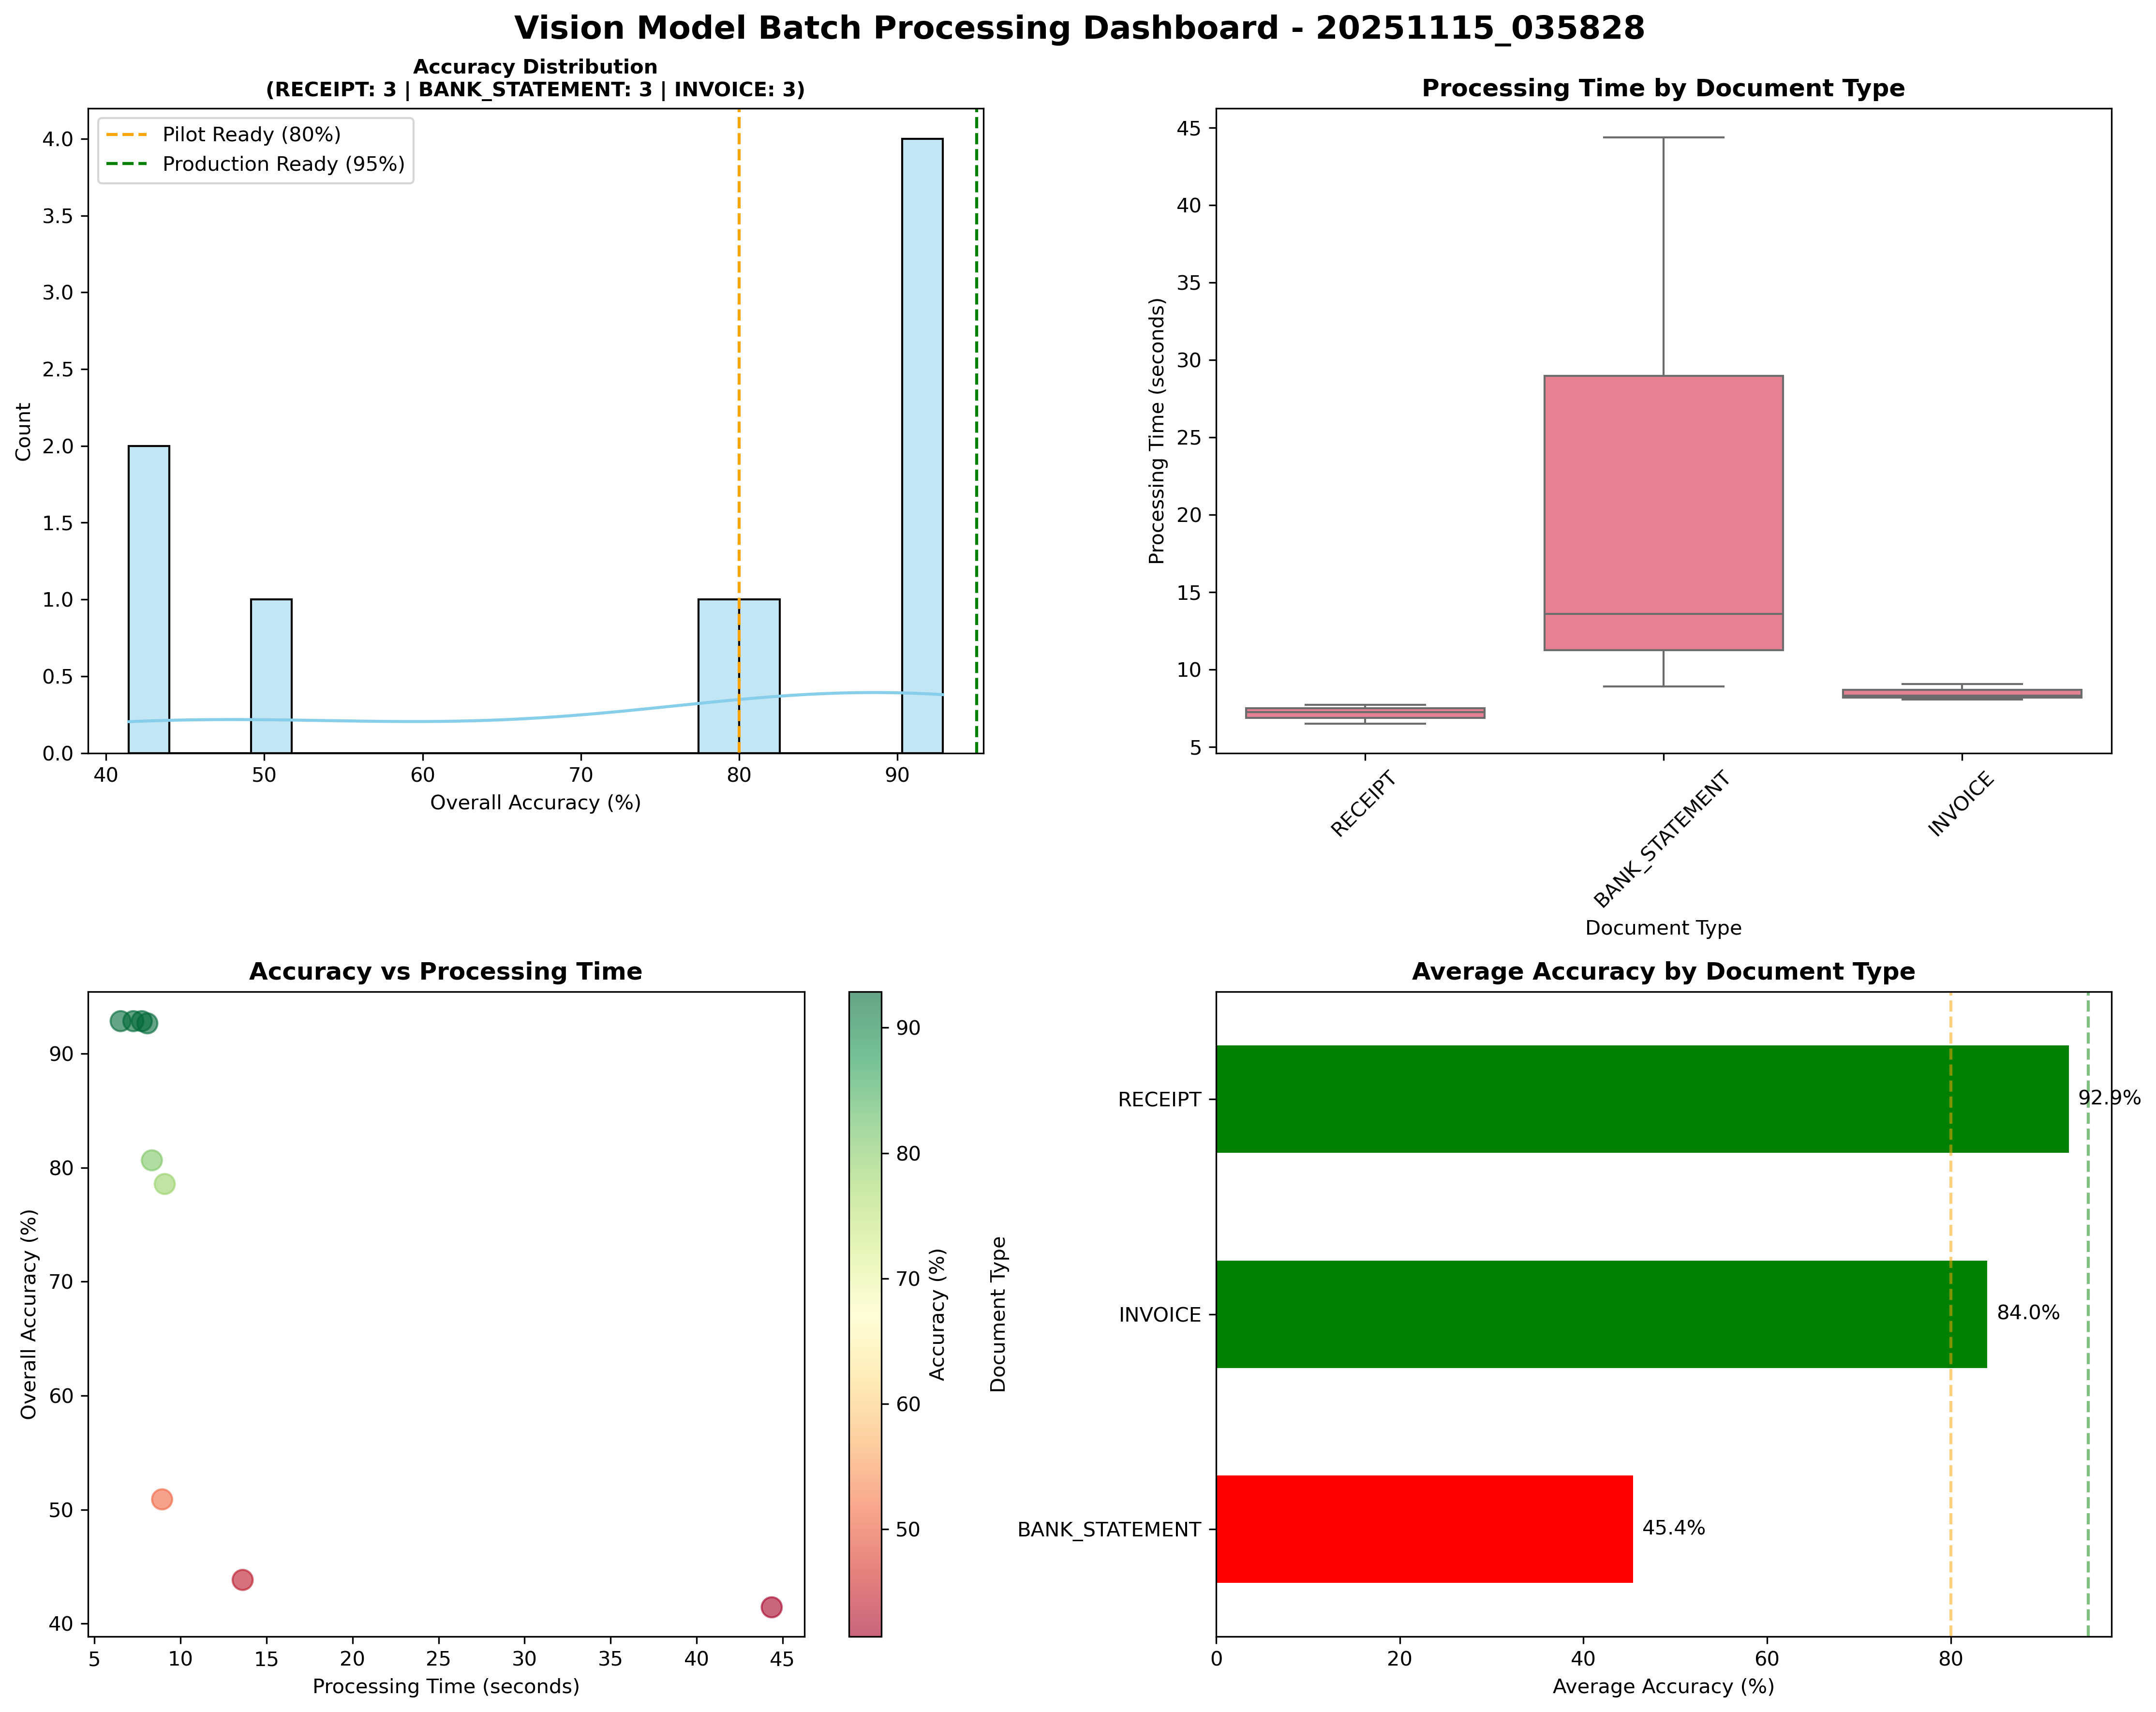

In [12]:
#Cell 12
# Display final summary
console.rule("[bold green]InternVL3 NON-QUANTIZED Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Overall Average Accuracy (across all images): {avg_accuracy:.2f}%[/cyan]")

# Show per-document-type breakdown
if len(df_results) > 0 and 'document_type' in df_results.columns:
    rprint("\n[bold blue]📊 Breakdown by Document Type:[/bold blue]")
    doc_type_stats = df_results.groupby('document_type').agg({
        'overall_accuracy': 'mean',
        'image_name': 'count'
    }).sort_values('overall_accuracy', ascending=False)
    
    for doc_type, row in doc_type_stats.iterrows():
        count = int(row['image_name'])
        acc = row['overall_accuracy']
        rprint(f"[cyan]  {doc_type.upper()}: {acc:.1f}% (n={count} images)[/cyan]")

rprint(f"\n[cyan]Output: {OUTPUT_BASE}[/cyan]")
rprint("[yellow]🔬 QUANTIZATION: DISABLED (testing non-quantized performance)[/yellow]")

# Performance assessment
if successful == total_images and avg_accuracy > 50:  # Reasonable thresholds
    rprint("\n[bold green]🎉 SUCCESS: Non-quantized InternVL3 appears to be working correctly![/bold green]")
    rprint("[green]✅ This proves the bug fixes (Rich recursion, prompt repetition) resolved the core issues[/green]")
    rprint("[green]✅ InternVL3-2B can run without quantization as it did before the problems emerged[/green]")
elif successful < total_images:
    rprint("\n[bold red]❌ FAILURE: Processing errors occurred[/bold red]")
    rprint("[red]🔍 This suggests quantization may still be required for stability[/red]")
elif avg_accuracy < 30:  # Very low accuracy threshold
    rprint("\n[bold yellow]⚠️ POOR PERFORMANCE: Very low accuracy detected[/bold yellow]")
    rprint("[yellow]🔍 Check if responses contain gibberish - may indicate quantization still needed[/yellow]")
else:
    rprint("\n[bold blue]📊 MIXED RESULTS: Partially working[/bold blue]")
    rprint("[blue]🔍 Review individual results to assess response quality[/blue]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]📋 Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

## 13. Failed Extractions

In [13]:
#Cell 13
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 9

Documents with 0% accuracy: 0

✅ No documents with 0% accuracy - all extractions had some success!